# Detecting Parkinson's Disease with XGBoost

This notebook uses data on biomedical voice measurements to train a XGBoost Classifier model in order to predict if a patient has Parkinson's Disease.
The dataset can be found here: https://archive.ics.uci.edu/ml/datasets/parkinsons.





In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# import the needed packages

import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, precision_score
from xgboost import XGBClassifier
%matplotlib inline



In [3]:
# import the data
data = pd.read_csv('/content/drive/My Drive/Parkinsons Classification/parkinsons.data')

In [4]:
# see the what the data looks like
data.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,0.02182,0.03130,0.02971,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,0.03134,0.04518,0.04368,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,0.02757,0.03858,0.03590,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,0.02924,0.04005,0.03772,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,0.03490,0.04825,0.04465,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [5]:
# inspect the data columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [6]:
# Even though the above cell shows there a null entries, I will check for missing data anyway just to make sure
missing_data = data.isnull().sum().sort_values(ascending=False)
print(missing_data)

PPE                 0
D2                  0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
name                0
dtype: int64


Now that it is known there is no missing data, the dataset can be split into X variables and the dependent y variable. Based on the dataset description on the UCI Machine Learning Respository the 'status' column is the dependent y variable with 0 for the patient does not have Parkinson's Disease and 1 if the patient does. The 'name' column is the patient's name and the rest of the columns are a range of biomedical voice measurements which will be used as the independent variables in the XGBoost algorithm in classifiying wether a patient has Parkinson's Disease.

In [7]:
# okay now that it is known that there is no missing data, the dataset can be split into X variables and the dependent y variable. 
X = copy.deepcopy(data)
X = X.drop(['name', 'status'], axis=1)
y = data['status'].values

print('dependent variables are:') 
print(X.columns)
print("")
print('first 5 rows of X column are:')
print(X.head())
print("")
print('first 50 instances of the status column are:')
print(y[:50])

dependent variables are:
Index(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1',
       'spread2', 'D2', 'PPE'],
      dtype='object')

first 5 rows of X column are:
   MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  ...   spread2        D2       PPE
0      119.992       157.302        74.997  ...  0.266482  2.301442  0.284654
1      122.400       148.650       113.819  ...  0.335590  2.486855  0.368674
2      116.682       131.111       111.555  ...  0.311173  2.342259  0.332634
3      116.676       137.871       111.366  ...  0.334147  2.405554  0.368975
4      116.014       141.781       110.655  ...  0.234513  2.332180  0.410335

[5 rows x 22 columns]

first 50 instances of the status column are:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 

In [8]:
# Now the data will be split into training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [9]:
# print sizes of training and testing sets for the X datasets
print('training set shape:')
print(X_train.shape)
print('validation set shape:')
print(X_valid.shape)
print('testing set shape:')
print(X_test.shape)

training set shape:
(124, 22)
validation set shape:
(32, 22)
testing set shape:
(39, 22)


In [10]:
# check for inbalance in the training set and compare it to the balance in the test set
print("ratio of negative instances to positive instances in the training set:")
neg_to_pos = np.sum(y_train == 0)/np.sum(y_train == 1)
print(neg_to_pos)
print("ratio of negative instances to positive instances in the test set:")
print(np.sum(y_test == 0)/np.sum(y_test == 1))



ratio of negative instances to positive instances in the training set:
0.34782608695652173
ratio of negative instances to positive instances in the test set:
0.21875


From the negative to positive instances ratio it can be seen that there are considerably more positive instances than negative instances. Therefore, to help with this imbalanced dataset the scale_pos_weight hyperamater will be included as one of the parameters to tune. More on this in the hyperparamer tuning section of this notebook.

In [11]:
# Now it is time to train a XGBoost model. Start with a basic model
xgb_model = XGBClassifier(objective='binary:logistic', use_label_encoder=True)
classifier0 = xgb_model.fit(X_train,
              y_train,
              eval_set=[(X_valid, y_valid)],
              eval_metric='aucpr',
              early_stopping_rounds = 15,
              verbose=True)

[0]	validation_0-aucpr:0.929912
Will train until validation_0-aucpr hasn't improved in 15 rounds.
[1]	validation_0-aucpr:0.931796
[2]	validation_0-aucpr:0.962899
[3]	validation_0-aucpr:0.949186
[4]	validation_0-aucpr:0.944597
[5]	validation_0-aucpr:0.93774
[6]	validation_0-aucpr:0.948926
[7]	validation_0-aucpr:0.946385
[8]	validation_0-aucpr:0.95687
[9]	validation_0-aucpr:0.953648
[10]	validation_0-aucpr:0.950168
[11]	validation_0-aucpr:0.950168
[12]	validation_0-aucpr:0.950168
[13]	validation_0-aucpr:0.959411
[14]	validation_0-aucpr:0.963658
[15]	validation_0-aucpr:0.962993
[16]	validation_0-aucpr:0.959771
[17]	validation_0-aucpr:0.962993
[18]	validation_0-aucpr:0.962993
[19]	validation_0-aucpr:0.965993
[20]	validation_0-aucpr:0.973651
[21]	validation_0-aucpr:0.971015
[22]	validation_0-aucpr:0.973651
[23]	validation_0-aucpr:0.97576
[24]	validation_0-aucpr:0.973651
[25]	validation_0-aucpr:0.973124
[26]	validation_0-aucpr:0.976136
[27]	validation_0-aucpr:0.978245
[28]	validation_0-aucpr

In [12]:
# check for overfitting in the model:
y_train_pred = classifier0.predict(X_train)
y_valid_pred = classifier0.predict(X_valid)
print('the training auc score is: ' + (str(roc_auc_score(y_train, y_train_pred))))
print('the validation auc score is: ' + (str(roc_auc_score(y_valid, y_valid_pred))))
(print(""))

print('the training precision score is: ' + (str(precision_score(y_train, y_train_pred))))
print('the validation precision score is: ' + (str(precision_score(y_valid, y_valid_pred))))

the training auc score is: 1.0
the validation auc score is: 0.8888888888888888

the training precision score is: 1.0
the validation precision score is: 0.92


In [13]:

y_test_pred = classifier0.predict(X_test)
print('the test auc score is: ' + (str(roc_auc_score(y_test, y_test_pred))))
print('the test precision score is: ' + (str(precision_score(y_test, y_test_pred))))

the test auc score is: 0.8571428571428572
the test precision score is: 0.9411764705882353


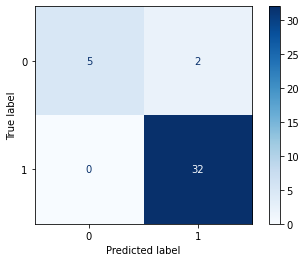

In [14]:
disp = plot_confusion_matrix(classifier0, X_test, y_test,
                             cmap=plt.cm.Blues,
                             normalize = None)

The model is doing very well so far with a high ability to distinguish between positive and negative instances (auc) and a high ratio of correct positive predictions to the total number of positive predictions (precision), however the differences in the training scores and validation scores could be an indication that there is overfitting in the model. Perhaps this can be improved with hyperparameter tuning 

In [15]:
#recheck the base parameters
classifier0.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, use_label_encoder=True, verbosity=1)>

From reading the documentation there are a number of ways to control for overfitting. The parameters listed in the documentation for preventing overfitting are max_depth, min_child_weight and gamma, subsample and colsample_bytree and eta. As well, lambda and alpha are regularization parameters that also help prevent overfitting.

Furthermore the dataset is imbalanced. There are significantly more istances where the participant has Parkinson's Disease than instances where the participant does not have Parkinson's Disease. The documentation reccomendeds setting the paremeter scale_pos_weight = sum(negative instances) / sum(positive instances). 

To find the optimal combination of hyperparameters to use in the model I am going to use RandomizedSearchCV where some of the parameters mentioned above will have a number of different values sampled.



In [17]:
# using RandomSearchCV

Param_Grid = { 'max_depth': [2,3,4,5,6],
               'eta' : [.05, .1, .15, .2, .25, .3,.35],
              'gamma' : [0,.25, .5, .75, 1],
              'reg_lamda' : [0, 1, 2, 3, 4, 5],
              'scale_pos_weight': [.1, .2, .3, .4, .5, .6, .7, .8],
              'colsample_bytree' : [.5, .6, .7, .8, .9, 1]
}

estimator = XGBClassifier(objective='binary:logistic', 
                          use_label_encoder=True)

random_search_xbgmodel = RandomizedSearchCV(estimator, 
                                   Param_Grid, 
                                   n_iter = 30,
                                   scoring = 'roc_auc',
                                   cv = 10,
                                   verbose = 0,
                                   random_state=42)

random_search_xbgmodel.fit(X_train,
                            y_train,
                            eval_set=[(X_valid, y_valid)],
                            eval_metric='aucpr',
                            early_stopping_rounds = 10,
                            verbose=False)

print('the optimal parameters are:')
print(random_search_xbgmodel.best_params_)


the optimal parameters are:
{'scale_pos_weight': 0.8, 'reg_lamda': 4, 'max_depth': 5, 'gamma': 0.25, 'eta': 0.35, 'colsample_bytree': 0.6}


Checking now to see if a model with these paramters yields better results


In [18]:
y_train_pred = random_search_xbgmodel.predict(X_train)
y_valid_pred = random_search_xbgmodel.predict(X_valid)
print('the training auc score is: ' + (str(roc_auc_score(y_train, y_train_pred))))
print('the validation auc score is: ' + (str(roc_auc_score(y_valid, y_valid_pred))))
(print(""))

print('the training precision score is: ' + (str(precision_score(y_train, y_train_pred))))
print('the validation precision score is: ' + (str(precision_score(y_valid, y_valid_pred))))

the training auc score is: 0.9735054347826086
the validation auc score is: 0.8454106280193238

the training precision score is: 0.989010989010989
the validation precision score is: 0.9130434782608695


In [19]:
y_test_pred = random_search_xbgmodel.predict(X_test)
print('the test auc score is: ' + (str(roc_auc_score(y_test, y_test_pred))))
print('the test precision score is: ' + (str(precision_score(y_test, y_test_pred))))

the test auc score is: 0.9129464285714287
the test precision score is: 0.96875


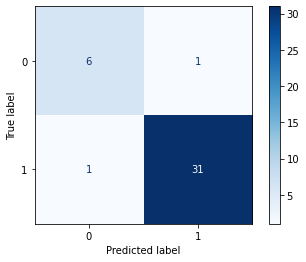

In [20]:
disp = plot_confusion_matrix(random_search_xbgmodel, X_test, y_test,
                             cmap=plt.cm.Blues,
                             normalize = None)

Okay! The overall performance of this model with hyperamter tuning is slightly better.  Even though the accuracies between the two models are identical the auc or equivalently the balanced accurary for the second model is higher as the second model is less likely to predict a false positive even though there are significantly more positive samples in the model. This quality of the second model can also be seen in the higher precision score which is equal to True Positives / (True Positives + False Positives)
